In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d nikitarom/planets-dataset

Saving kaggle.json to kaggle.json
 99% 1.48G/1.50G [00:15<00:00, 111MB/s]
100% 1.50G/1.50G [00:15<00:00, 105MB/s]


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12552977207407159907
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16970761887042203040
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
import tensorflow as tf

try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [6]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,Concatenate
from keras.layers import Dense,Dropout,Activation
from keras.layers import Flatten,BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.vgg19 import VGG19
from  keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import cv2
from sklearn import svm


In [7]:
from zipfile import ZipFile 
with ZipFile('planets-dataset.zip', 'r') as zip: 

    print('Extracting all the files now...') 
    zip.extractall('data')


Extracting all the files now...


In [8]:
from pandas import read_csv
# load file as CSV
filename = 'data/planet/planet/train_classes.csv'
df_train_data = read_csv(filename)
# summarize properties
print(df_train_data.shape)

(40479, 2)


In [28]:
df_train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## **Split the dataset**

In [32]:
df_train,df_valid = train_test_split(df_train_data,test_size= 0.3)

## **Visualize Dataset**
The first step is to inspect some of the images in the training dataset.

In [10]:
input_size = 128
input_channels = 3

epochs = 50
batch_size = 128

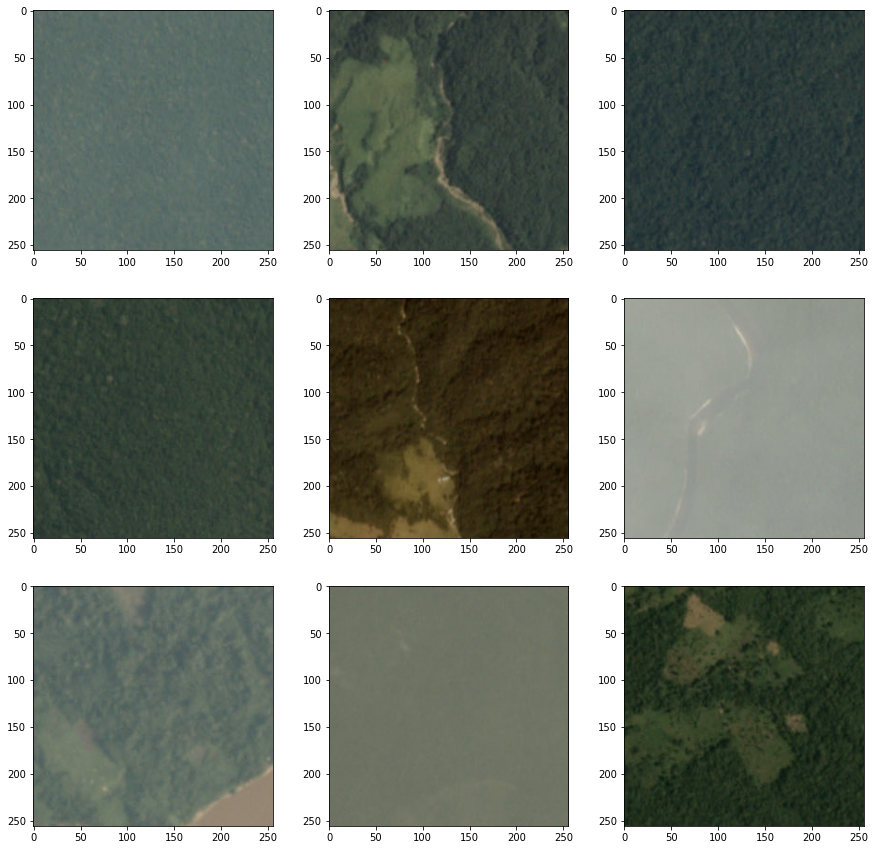

In [11]:
folder = "data/planet/planet/train-jpg/"
fig,axes = plt.subplots(3,3,figsize=(15,15))
axes = [ax for axes_row in axes for ax in axes_row]
for i in range(9):
  img = folder + 'train_' + str(i) + '.jpg'
  image = imread(img)
  axes[i].imshow(image)


We can create a dictionary that maps tags to integers so that we can encode the training dataset for modeling.

We can also create a dictionary with the reverse mapping from integers to string tag values, so later when the model makes a prediction, we can turn it into something readable.

In [12]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [13]:
label_map

{'agriculture': 16,
 'artisinal_mine': 14,
 'bare_ground': 15,
 'blooming': 11,
 'blow_down': 12,
 'clear': 7,
 'cloudy': 9,
 'conventional_mine': 5,
 'cultivation': 1,
 'habitation': 0,
 'haze': 2,
 'partly_cloudy': 10,
 'primary': 6,
 'road': 4,
 'selective_logging': 13,
 'slash_burn': 8,
 'water': 3}

In [14]:
n_folds = 5

training = True

fold_count = 0

y_full_test = []
thres_sum = np.zeros(17, np.float32)

## **data generator**

In [15]:

def transformations(src, choice):
    if choice == 0:
        # Rotate 90
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
    if choice == 1:
        # Rotate 90 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    if choice == 2:
        # Rotate 180
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
    if choice == 3:
        # Rotate 180 and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_180)
        src = cv2.flip(src, flipCode=1)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
    if choice == 5:
        # Rotate 90 counter-clockwise and flip horizontally
        src = cv2.rotate(src, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        src = cv2.flip(src, flipCode=1)
    return src



def valid_generator():
    while True:
        for start in range(0, len(df_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_valid))
            df_valid_batch = df_valid[start:end]
            for f, tags in df_valid_batch.values:
                img = cv2.imread('data/planet/planet/train-jpg/{}.jpg'.format(f))
                img = cv2.resize(img, (input_size, input_size))
                img = transformations(img, np.random.randint(6))
                img = img/255
                targets = np.zeros(17)
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
                x_batch.append(img)
                y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch


def train_generator():
    while True:
        for start in range(0, len(df_train), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df_train))
            df_train_batch = df_train[start:end]
            for f, tags in df_train_batch.values:
                img = cv2.imread('data/planet/planet/train-jpg/{}.jpg'.format(f))
                img = cv2.resize(img, (input_size, input_size))
                img = transformations(img, np.random.randint(6))
                img = img/255
                targets = np.zeros(17)
                for t in tags.split(' '):
                    targets[label_map[t]] = 1
                x_batch.append(img)
                y_batch.append(targets)
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

## **Training Data Generator**

In [16]:
train_gen = train_generator()
train_x,train_y = next(train_gen)
print(train_x.shape)
print(train_y.shape)

(128, 128, 128, 3)
(128, 17)


In [17]:
def target_fun(y):
    a = [i for i in range(17) if y[i]==1]
    s = [inv_label_map[i] for i in a]
    return s


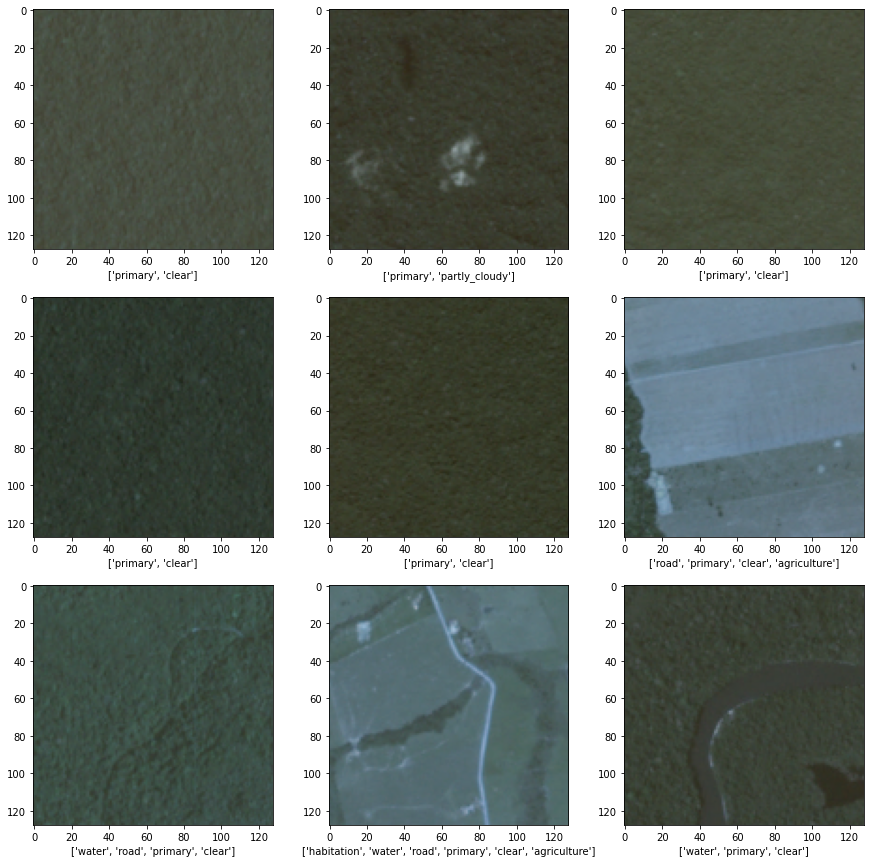

In [18]:
fig,axes = plt.subplots(3,3,figsize=(15,15))
axes = [ax for axes_row in axes for ax in axes_row]
for i in range(9):
    axes[i].set_xlabel(target_fun(train_y[i]))
    axes[i].imshow(train_x[i])


## **Valid data generator**

In [19]:
valid_gen = valid_generator()
valid_x,valid_y = next(valid_gen)
print(valid_x.shape)
print(valid_y.shape)

(128, 128, 128, 3)
(128, 17)


## **Model Evaluation Measure**

In [20]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
	# clip predictions
	y_pred = backend.clip(y_pred, 0, 1)
	# calculate elements
	tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
	fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
	fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
	# calculate precision
	p = tp / (tp + fp + backend.epsilon())
	# calculate recall
	r = tp / (tp + fn + backend.epsilon())
	# calculate fbeta, averaged across each class
	bb = beta ** 2
	fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
	return fbeta_score

## **Input Shape and Output shape of model**

In [21]:
in_shape=(128, 128, 3)
out_shape=17

## **learning curves**

In [22]:
def display_curve(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'],color='blue', label='train')
    plt.plot(history.history['val_loss'],color='orange',label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'],color='blue',label='train')
    plt.plot(history.history['val_fbeta'],color='orange',label='test')
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename+'_plot.png')
    plt.show()
    plt.close()


In [114]:
score=[]

## **Baseline Model**

In [30]:

# define cnn model
model = Sequential()
model.add(Conv2D(32,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same', input_shape=in_shape))
model.add(Conv2D(32,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(64,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(128,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(256,(2,2),activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(out_shape, activation='sigmoid'))


In [31]:
opt = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=[fbeta])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [32]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', 
    monitor='val_fbeta', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)
early =tf.keras.callbacks.EarlyStopping(monitor="val_fbeta", 
                    mode="max", 
                    patience=15)


In [33]:

history=model.fit_generator(generator=train_generator(),
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=50,
                            verbose=1,
                            callbacks= [ checkpoint,early] ,
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
222/222 [==============================] - 78s 319ms/step - loss: 0.3185 - fbeta: 0.6081 - val_loss: 0.2717 - val_fbeta: 0.6758

Epoch 00001: val_fbeta improved from -inf to 0.67583, saving model to ./best_model.h5
Epoch 2/50
222/222 [==============================] - 70s 315ms/step - loss: 0.2139 - fbeta: 0.6763 - val_loss: 0.2528 - val_fbeta: 0.6920

Epoch 00002: val_fbeta improved from 0.67583 to 0.69202, saving model to ./best_model.h5
Epoch 3/50
222/222 [==============================] - 70s 317ms/step - loss: 0.2074 - fbeta: 0.6917 - val_loss: 0.2497 - val_fbeta: 0.6796

Epoch 00003: val_fbeta did not improve from 0.69202
Epoch 4/50
222/222 [==============================] - 70s 317ms/step - loss: 0.2024 - fbeta: 0.7034 - val_loss: 0.2507 - val_fbeta: 0.6651

Epoch 00004: val_fbeta did not improve from 0.69202
Epoch 5/50
222/222 [==============================] - 70s 315ms/step - loss: 0.1982 - fbeta: 0.7137 - val_loss: 0.2503 - val_fbeta: 0.6607

Epoch 00005: val_fbet

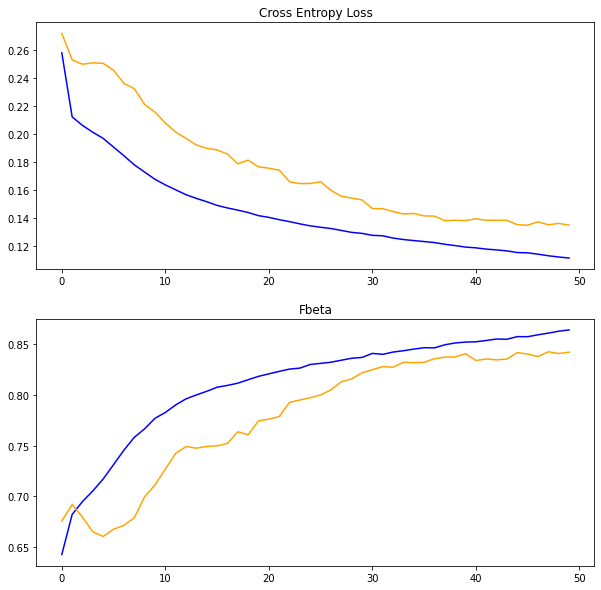

In [34]:
display_curve(history)

## **Saving the Model for Furter use**
hear we dont have to save our model weight file because it is already save in model checkpoints


In [35]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [92]:
model.load_weights('best_model.h5')

In [115]:

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=[fbeta])
value = model.evaluate(valid_generator(),steps=(len(df_valid) // batch_size) + 1,verbose=0)
_,acc = model.evaluate(train_generator(),steps=(len(df_train) // batch_size) + 1,verbose=0)
print("Validation loss :",value[0])
print("Validation IOU  :",value[1])
score.append(value)

Validation loss : 1.4215590953826904
Validation IOU  : 0.12168698757886887


## **Transfer learning**
### **1. VGG19**

In [33]:
base_model = VGG19(include_top=False,weights='imagenet',input_shape=in_shape)
model_vgg = Sequential()
model_vgg.add(base_model)
model_vgg.add(Flatten())
model_vgg.add(Dense(128,activation='relu'))
model_vgg.add(Dense(out_shape, activation='sigmoid'))

In [34]:
 opt = Adam(lr=1e-4)
 model_vgg.compile(loss='binary_crossentropy',
                  # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer=opt,
                  metrics=[fbeta])
 model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_3 (Dense)              (None, 17)                2193      
Total params: 21,075,281
Trainable params: 21,075,281
Non-trainable params: 0
_________________________________________________________________


In [35]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_cgg.h5', 
    monitor='val_fbeta', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)
early =tf.keras.callbacks.EarlyStopping(monitor="val_fbeta", 
                      mode="max", 
                      patience=15)

In [36]:
history=model_vgg.fit_generator(generator=train_generator(),
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=20,
                            verbose=1,
                            callbacks=[ checkpoint,early],
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
222/222 [==============================] - 157s 704ms/step - loss: 0.2416 - fbeta: 0.6957 - val_loss: 0.1368 - val_fbeta: 0.8254

Epoch 00001: val_fbeta improved from -inf to 0.82541, saving model to ./best_model_cgg.h5
Epoch 2/20
222/222 [==============================] - 157s 707ms/step - loss: 0.1256 - fbeta: 0.8505 - val_loss: 0.1174 - val_fbeta: 0.8629

Epoch 00002: val_fbeta improved from 0.82541 to 0.86285, saving model to ./best_model_cgg.h5
Epoch 3/20
222/222 [==============================] - 157s 706ms/step - loss: 0.1108 - fbeta: 0.8712 - val_loss: 0.1123 - val_fbeta: 0.8705

Epoch 00003: val_fbeta improved from 0.86285 to 0.87050, saving model to ./best_model_cgg.h5
Epoch 4/20
222/222 [==============================] - 157s 707ms/step - loss: 0.1053 - fbeta: 0.8772 - val_loss: 0.1050 - val_fbeta: 0.8753

Epoch 00004: val_fbeta improved from 0.87050 to 0.87526, saving model to ./best_model_cgg.h5
Epoch 5/20
222/222 [==============================] - 157s 707ms/st

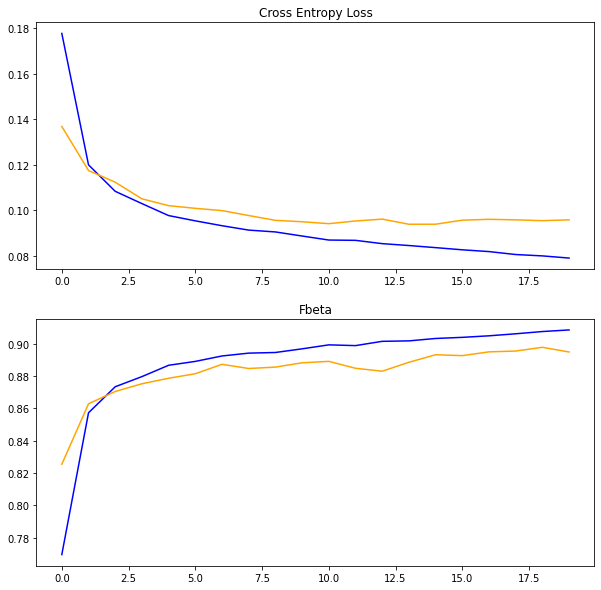

In [37]:
display_curve(history)

## **Saving the Model for Furter use**
hear we dont have to save our model weight file because it is already save in model checkpoints


In [38]:
model_json = model_vgg.to_json()
with open("model_vgg.json", "w") as json_file:
    json_file.write(model_json)

In [116]:

model_vgg.compile(loss='binary_crossentropy',optimizer=opt,metrics=[fbeta])
value = model_vgg.evaluate(valid_generator(),steps=(len(df_valid) // batch_size) + 1,verbose=0)
_,acc = model_vgg.evaluate(train_generator(),steps=(len(df_train) // batch_size) + 1,verbose=0)
print("Validation loss :",value[0])
print("Validation Fbeta   :",value[1])
print("Train Fbeta :",acc)
score.append(value)

Validation loss : 0.0962286964058876
Validation Fbeta   : 0.8937843441963196
Train Fbeta : 0.9051171541213989


In [41]:
score.append(value)

### **2. ResNet50**

In [42]:
from keras.applications.resnet50 import ResNet50
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top=False,weights='imagenet',input_shape=in_shape))
model_resnet.add(Flatten())
model_resnet.add(Dense(128,activation='relu'))
model_resnet.add(Dropout(0.4))
model_resnet.add(Dense(out_shape, activation='sigmoid'))

94773248/94765736 [==============================] - 1s 0us/step


In [44]:
 opt = Adam(lr=1e-4)
 model_resnet.compile(loss='binary_crossentropy',
                  # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer=opt,
                  metrics=[fbeta])
 model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 17)                2193      
Total params: 27,784,337
Trainable params: 27,731,217
Non-trainable params: 53,120
_________________________________________________________________


In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_resnet.h5', 
    monitor='val_fbeta', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)
early =tf.keras.callbacks.EarlyStopping(monitor="val_fbeta", 
                      mode="max", 
                      patience=6)

In [46]:
history= model_resnet.fit_generator(generator=train_generator(),
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=20,
                            verbose=1,
                            callbacks=[ checkpoint,early],
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
222/222 [==============================] - 124s 532ms/step - loss: 0.2748 - fbeta: 0.7419 - val_loss: 0.5562 - val_fbeta: 0.3985

Epoch 00001: val_fbeta improved from -inf to 0.39849, saving model to ./best_model_resnet.h5
Epoch 2/20
222/222 [==============================] - 116s 524ms/step - loss: 0.1451 - fbeta: 0.8513 - val_loss: 0.4338 - val_fbeta: 0.3267

Epoch 00002: val_fbeta did not improve from 0.39849
Epoch 3/20
222/222 [==============================] - 116s 522ms/step - loss: 0.1249 - fbeta: 0.8688 - val_loss: 0.3352 - val_fbeta: 0.3799

Epoch 00003: val_fbeta did not improve from 0.39849
Epoch 4/20
222/222 [==============================] - 116s 522ms/step - loss: 0.1120 - fbeta: 0.8799 - val_loss: 0.2669 - val_fbeta: 0.5329

Epoch 00004: val_fbeta improved from 0.39849 to 0.53291, saving model to ./best_model_resnet.h5
Epoch 5/20
222/222 [==============================] - 116s 522ms/step - loss: 0.1033 - fbeta: 0.8898 - val_loss: 0.1509 - val_fbeta: 0.7885

Ep

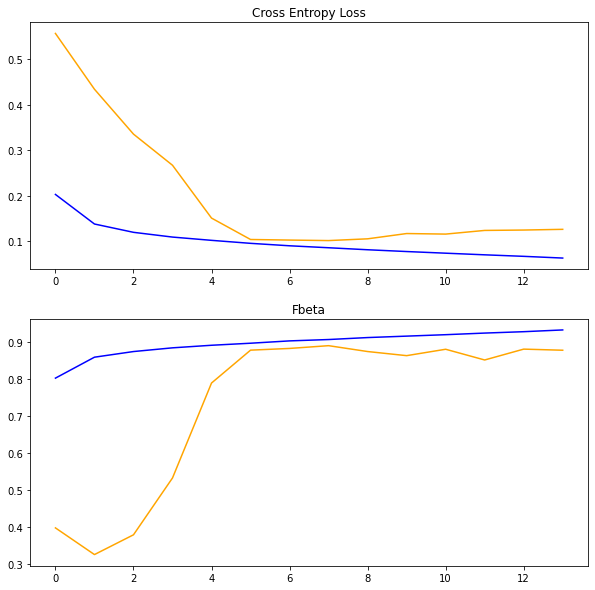

In [47]:
display_curve(history)

## **Saving the Model for Furter use**
hear we dont have to save our model weight file because it is already save in model checkpoints


In [49]:
model_json = model_resnet.to_json()
with open("model_resnet.json", "w") as json_file:
    json_file.write(model_json)

In [51]:
model_resnet.load_weights('best_model_resnet.h5')

In [117]:

model_resnet.compile(loss='binary_crossentropy',optimizer=opt,metrics=[fbeta])
value = model_resnet.evaluate(valid_generator(),steps=(len(df_valid) // batch_size) + 1,verbose=0)
_,acc = model_resnet.evaluate(train_generator(),steps=(len(df_train) // batch_size) + 1,verbose=0)
print("Validation loss :",value[0])
print("Validation Fbeta  :",value[1])
print("Train Fbeta : ",acc)
score.append(value)

Validation loss : 0.10086212307214737
Validation Fbeta  : 0.8904035091400146
Train Fbeta :  0.9132235646247864


## **4. InceptionV3**

In [57]:
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=in_shape)

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.4))
add_model.add(Dense(out_shape, activation='sigmoid'))

In [58]:
opt = Adam(lr=1e-4)
add_model.compile(loss='binary_crossentropy',
                  # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                  optimizer=opt,
                  metrics=[fbeta])
add_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 17)                34833     
Total params: 21,837,617
Trainable params: 21,803,185
Non-trainable params: 34,432
_________________________________________________________________


In [59]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_inception.h5', 
    monitor='val_fbeta', mode='max', 
    save_best_only=True, save_weights_only=True, 
    verbose=1
)
early =tf.keras.callbacks.EarlyStopping(monitor="val_fbeta", 
                      mode="max", 
                      patience=10)

In [61]:
history= add_model.fit_generator(generator=train_generator(),
                            steps_per_epoch=(len(df_train) // batch_size) + 1,
                            epochs=10,
                            verbose=1,
                            callbacks=[ checkpoint,early],
                            validation_data=valid_generator(),
                            validation_steps=(len(df_valid) // batch_size) + 1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
222/222 [==============================] - 85s 383ms/step - loss: 0.1858 - fbeta: 0.8099 - val_loss: 0.1471 - val_fbeta: 0.8016

Epoch 00001: val_fbeta improved from -inf to 0.80162, saving model to ./best_model_inception.h5
Epoch 2/10
222/222 [==============================] - 83s 374ms/step - loss: 0.1119 - fbeta: 0.8717 - val_loss: 0.1084 - val_fbeta: 0.8736

Epoch 00002: val_fbeta improved from 0.80162 to 0.87355, saving model to ./best_model_inception.h5
Epoch 3/10
222/222 [==============================] - 84s 378ms/step - loss: 0.1009 - fbeta: 0.8831 - val_loss: 0.1042 - val_fbeta: 0.8780

Epoch 00003: val_fbeta improved from 0.87355 to 0.87799, saving model to ./best_model_inception.h5
Epoch 4/10
222/222 [==============================] - 84s 378ms/step - loss: 0.0929 - fbeta: 0.8935 - val_loss: 0.1005 - val_fbeta: 0.8872

Epoch 00004: val_fbeta improved from 0.87799 to 0.88724, saving model to ./best_model_inception.h5
Epoch 5/10
222/222 [===========================

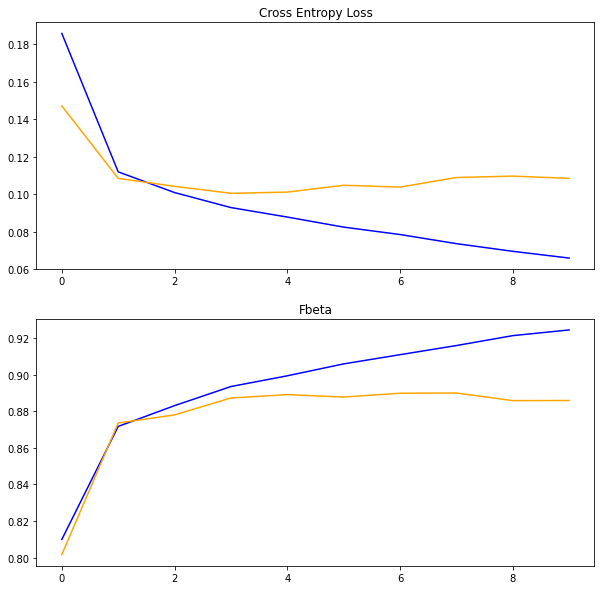

In [62]:
 display_curve(history)

## **Saving the Model for Furter use**
hear we dont have to save our model weight file because it is already save in model checkpoints


In [63]:
model_json = add_model.to_json()
with open("model_inception.json", "w") as json_file:
    json_file.write(model_json)

In [64]:
add_model.load_weights('best_model_inception.h5')

In [119]:

add_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=[fbeta])
value = add_model.evaluate(valid_generator(),steps=(len(df_valid) // batch_size) + 1,verbose=0)
_,acc = add_model.evaluate(train_generator(),steps=(len(df_train) // batch_size) + 1,verbose=0)
print("Validation loss :",value[0])
print("Validation Fbeta  :",value[1])
print("Train Fbeta : ",acc)
score.append(value)

Validation loss : 0.10937891155481339
Validation Fbeta  : 0.8886702656745911
Train Fbeta :  0.9170385003089905


In [113]:
json_file = open('model(1).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model= model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("best_model(1).h5")
print("Loaded model from disk")

Loaded model from disk


In [120]:
Score = pd.DataFrame(score)
Score.columns = ['Loss','fbeta']
Score['Model Name'] = ['BaseLine Model','VGG19','RESNET50','Inception']
Score.set_index('Model Name')
Score.head()

,Loss,fbeta,Model Name
0,1.421559,0.121687,BaseLine Model
1,0.096229,0.893784,VGG19
2,0.100862,0.890404,RESNET50
3,0.109379,0.888670,Inception


In [121]:
all_models = []
for model in [model_vgg,model_resnet,add_model]:
  all_models.append(model)
